In [1]:
import nltk
import torch
import torchvision
import numpy as np
import string
import time
import pickle
import unicodedata
import torch.nn as nn
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove*.zip

In [2]:
# important constants
char_embedding_dim = 30
word_embedding_dim = 100
max_word_len = 40
dropout_prob = 0.5
num_cnn_filter = 30
char_kernel_size = 3
rnn_hidden_dim = 100
word_embedding_path = 'glove.6B/glove.6B.{}d.txt'.format(word_embedding_dim)
lr = 0.01
lr_decay = 0.05
min_epoches = 50
momentum = 0.9
batch_size = 10

In [3]:
# setting the device to gpu if cuda is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
'''
    Utility functions
'''

# datastructure for storing the id and val mapping
class unique_dict:
    def __init__(self):
        self.id = 0
        self.id2val = dict()
        self.val2id = dict()
        self.vals = set()
        
    def get_length(self):
        return self.id
    
    def store(self, val):
        self.id2val[self.id] = val
        self.val2id[val] = self.id
        self.vals.add(val)
        self.id += 1
    
    def fetch(self, key, by='id'):
        if by == 'id':
            return self.id2val[key]
        elif key in self.vals:
            return self.val2id[key]
        else:
            return None

# intializes the word unique_dict and embedding matrix
def generate_words_embedding(embedding_path):
    words = unique_dict()
    word_embedding = list()
    
    with open(embedding_path, 'rb') as embedding_file:
        for encoded_line in tqdm(embedding_file):
            line = encoded_line.decode().split()
            words.store(line[0])
            embedding = np.array(line[1:]).astype(np.float)
            word_embedding.append(embedding)
    
    word_embedding = np.array(word_embedding)
    other_embedding = np.sum(word_embedding, axis=0) / len(word_embedding) 
            
    return words, np.vstack([word_embedding, other_embedding])

# for parsing train.txt and test.txt
def parse_dataset(file_name):
    
    # time initialized
    tic = time.time()
    
    # to be returned
    tokenized_sentences = []
    pos_tags = []
    chunking_tags = []
    
    # reading the file_name
    curr_sent = []
    curr_pos_tags = []
    curr_chunking_tags = []
    with open(file_name, 'r') as read_file:
        for line in tqdm(read_file.readlines()):
            
            # sentence end condition:
            if line == '\n':
                tokenized_sentences.append(curr_sent)
                pos_tags.append(curr_pos_tags)
                chunking_tags.append(curr_chunking_tags)
                curr_sent = []
                curr_pos_tags = []
                curr_chunking_tags = []
                
            # appending the values in respective lists
            else:
                token, pos_tag, chunk_tag = line.strip('\n').split(' ')
                curr_sent.append(token)
                curr_pos_tags.append(pos_tag)
                curr_chunking_tags.append(chunk_tag[0])
                
    toc = time.time()
    print('Time elapsed for parsing {}:'.format(file_name), toc - tic)
                
    return tokenized_sentences, pos_tags, chunking_tags

# functions for getting the POS tags and chunking tags
def get_pos_chunking_tags(pos_tags, chunking_tags):
    pos_tag_dict = unique_dict()
    chunking_tag_dict = unique_dict()
    chunking_tag_dict.store('dummy')
    
    # retrieving the tags together
    for pos_tag_seq, chunking_tag_seq in tqdm(zip(pos_tags, chunking_tags)):
        for pos_tag, chunking_tag in zip(pos_tag_seq, chunking_tag_seq):
            if pos_tag_dict.fetch(pos_tag, 'val') is None:
                pos_tag_dict.store(pos_tag)
            if chunking_tag_dict.fetch(chunking_tag, 'val') is  None:
                chunking_tag_dict.store(chunking_tag)
    return pos_tag_dict, chunking_tag_dict

In [5]:
# initializing character unique_dict for ascii characters only
def generate_unique_characters():
    char_list = ''.join([chr(i) for i in range(128)])
    characters = unique_dict()
    for char in char_list:
        characters.store(char)
    return characters

# character level word encoder
class Encoder(nn.Module):
    def __init__(self, characters, words, word_embedding):
        super(Encoder, self).__init__()
        self.characters = characters
        self.words = words
        
        # embedding layer utils
        self.word_embedding = torch.from_numpy(word_embedding)
        self.char_embedding = nn.Embedding(characters.id + 2, char_embedding_dim) # unk char => 128, pad char => 129 
        nn.init.uniform_(self.char_embedding.weight, a=-(3/char_embedding_dim)**0.5, b=(3/char_embedding_dim)**0.5)
        
        # dropout utils
        self.dropout = nn.Dropout(p=dropout_prob)
        
        # character convolution
        self.convolution = nn.Conv1d(
            in_channels=char_embedding_dim,
            out_channels=char_embedding_dim * num_cnn_filter,
            kernel_size=char_kernel_size,
            groups=char_embedding_dim
        )
        nn.init.xavier_uniform_(self.convolution.weight, gain=1.0)
        nn.init.zeros_(self.convolution.bias)
    
    def forward(self, word_sequences):
        batch_count = len(word_sequences)
        seq_len = [len(seq) for seq in word_sequences]
        max_seq_len = max(seq_len)
        expanded_seq = [[[char for char in word] for word in seq] for seq in word_sequences]
        word_seq_tensor = torch.zeros(batch_count, max_seq_len, max_word_len, dtype=torch.long, device=device)
        
        # converting list of sequences of list of words of list of characters to corresponding ids
        for batch_id, curr_seq in enumerate(expanded_seq):
            curr_seq_id = list()
            for word in curr_seq:
                word_id = [self.characters.fetch(char, 'val') or self.characters.id for char in word]
                word_id = torch.LongTensor(word_id).to(device)
                
                # center padding for the word
                pad = [(max_word_len - len(word)) // 2, (max_word_len - len(word) + 1) // 2]
                word_id = nn.functional.pad(word_id, pad, value=self.characters.id + 1)
                curr_seq_id.append(word_id)
            
            # appending the sequence to the word_seq_tensor
            curr_seq_tensor = torch.zeros(len(curr_seq_id), max_word_len, dtype=torch.long, device=device)
            curr_seq_tensor = torch.stack(curr_seq_id)
            word_seq_tensor[batch_id, :curr_seq_tensor.shape[0], :] = curr_seq_tensor
        
        # generating embeddings character level
        word_seq_embeddings = self.char_embedding(word_seq_tensor)
        word_seq_embeddings = word_seq_embeddings.permute(0, 1, 3, 2)
        
        # applying the dropout
        word_seq_embeddings = self.dropout(word_seq_embeddings)
        
        # convolution and max pooling
        max_pooling_output = torch.zeros(
            word_seq_embeddings.shape[0],
            word_seq_embeddings.shape[1],
            char_embedding_dim * num_cnn_filter,
            dtype=torch.float,
            device=device,
        )
        for word_id in range(max_seq_len):
            max_pooling_output[:, word_id, :], _ = torch.max(self.convolution(word_seq_embeddings[:, word_id, :, :]), dim=2)
            
        # indexing the words according to the vocabulary
        seq_word_indices = torch.ones(batch_count, max_seq_len, dtype=torch.int32, device=device) * (self.word_embedding.shape[0] - 1)
        for (row_index, seq) in enumerate(word_sequences):
            for (column_index, word) in enumerate(seq):
                seq_word_indices[row_index, column_index] = self.words.fetch(word.lower(), 'val') or (self.word_embedding.shape[0] - 2)
        
        # generating the word embedding
        word_embeddings_glove = torch.zeros(batch_count, max_seq_len, word_embedding_dim, device=device)
        for row_index in range(seq_word_indices.shape[0]):
            for column_index in range(seq_word_indices.shape[1]):
                word_embeddings_glove[row_index, column_index, :] = self.word_embedding[seq_word_indices[row_index, column_index]]
        word_embeddings_glove = self.dropout(word_embeddings_glove)
        
        # stacking the character level and word level embedding and returning the seq_le
        return torch.cat([max_pooling_output, word_embeddings_glove], dim=2), seq_len

# birnn custom class
class BilstmCustom(nn.Module):
    def __init__(self):
        super(BilstmCustom, self).__init__()
        
        # rnn layer initializations
        self.rnn = nn.LSTM(
            input_size=char_embedding_dim * num_cnn_filter + word_embedding_dim,
            hidden_size=rnn_hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        nn.init.xavier_uniform_(self.rnn.weight_hh_l0)
        nn.init.xavier_uniform_(self.rnn.weight_hh_l0_reverse)
        nn.init.xavier_uniform_(self.rnn.weight_ih_l0)
        nn.init.xavier_uniform_(self.rnn.weight_ih_l0_reverse)
        self.rnn.bias_hh_l0.data.fill_(0)
        self.rnn.bias_hh_l0_reverse.data.fill_(0)
        self.rnn.bias_ih_l0.data.fill_(0)
        self.rnn.bias_ih_l0_reverse.data.fill_(0)
        self.h_0 = torch.zeros(2, batch_size, rnn_hidden_dim, device=device, requires_grad=False)
        self.c_0 = torch.zeros(2, batch_size, rnn_hidden_dim, device=device, requires_grad=False)
        
        # setting a specific section of the bias = 1
        for names in self.rnn._all_weights:
            for name in filter(lambda n: 'bias' in n, names):
                bias = getattr(self.rnn, name)
                n = bias.size(0)
                start, end = n // 4, n // 2
                bias.data[start:end].fill_(1.)
        
    # sorts the sequence in the decreasing order, also returns the indexes in reverse order
    def reverse_seq_len_sort(self, seq_len_list):
        data_num = len(seq_len_list)
        sort_indices = sorted(range(len(seq_len_list)), key=seq_len_list.__getitem__, reverse=True)
        reverse_sort_indices = [-1 for _ in range(data_num)]
        for i in range(data_num):
            reverse_sort_indices[sort_indices[i]] = i
        sort_index = torch.tensor(sort_indices, dtype=torch.long).to(device)
        reverse_sort_index = torch.tensor(reverse_sort_indices, dtype=torch.long).to(device)
        return sorted(seq_len_list, reverse=True), sort_index, reverse_sort_index
    
    # used for packing the sequences
    # returns the packed input tensor along with reverse_sort_index to return back original order
    def pack(self, input_tensor, seq_len_list):
        sorted_seq, sort_index, reverse_sort_index = self.reverse_seq_len_sort(seq_len_list)
        input_tensor_sorted = torch.index_select(input_tensor, dim=0, index=sort_index)
        return nn.utils.rnn.pack_padded_sequence(input_tensor_sorted, lengths=sorted_seq, batch_first=True), reverse_sort_index
    
    # used to nullify the effect of the above
    def unpack(self, output_packed_tensor, max_seq_len, reverse_sort_index):
        output_tensor, _ = nn.utils.rnn.pad_packed_sequence(output_packed_tensor, batch_first=True, total_length=max_seq_len)
        output_original_tensor = torch.index_select(output_tensor, dim=0, index=reverse_sort_index)
        return output_original_tensor
    
    def forward(self, seq_word_embeddings, seq_len):
        num_batch, max_seq_len, _ = seq_word_embeddings.shape
        seq_word_embeddings_packed, reverse_sort_index = self.pack(seq_word_embeddings, seq_len)
        output_packed_tensor, (h_0, c_0) = self.rnn(seq_word_embeddings_packed, (self.h_0, self.c_0))
        self.h_0 = h_0.detach()
        self.c_0 = c_0.detach()
        return self.unpack(output_packed_tensor, max_seq_len, reverse_sort_index)
    
class CnnLstm(nn.Module):
    def __init__(self, encoder, biLstmCustom, tags):
        super(CnnLstm, self).__init__()
        
        # encoders and rnn layers
        self.encoder = encoder
        self.biLstmCustom = biLstmCustom

        # a drop out layer
        self.dropout = nn.Dropout(p=dropout_prob)
        
        # linear layer
        self.linear = nn.Linear(in_features=rnn_hidden_dim * 2, out_features=tags.id)
        self.log_soft_max = nn.LogSoftmax(dim=1)
        
        # loss layer
        self.nll_loss = nn.NLLLoss(ignore_index=0)
        
    def forward(self, word_sequences):
        # deriving the encodings at character level and word level
        seq_word_embeddings, seq_len = self.encoder(word_sequences)
        
        # applying the rnn layer
        rnn_output_tensor = self.biLstmCustom(seq_word_embeddings, seq_len)
        rnn_output_tensor = self.dropout(rnn_output_tensor)
        
        # application of linear layer
        linear_output = self.linear(rnn_output_tensor)
        linear_output_log = self.log_soft_max(linear_output.permute(0, 2, 1))
        return linear_output_log, seq_len
    
    def cross_entropy_loss(self, mini_batch_word_sequences, mini_batch_tag_sequences):
        output_log_likelihood, _ = self.forward(mini_batch_word_sequences)
        loss = self.nll_loss(output_log_likelihood, mini_batch_tag_sequences)
        return loss

In [ ]:
# dataset parsing
train_sent, train_pos_tags, train_chunking_tags = parse_dataset('train.txt')
test_sent, test_pos_tags, test_chunking_tags = parse_dataset('test.txt')
pos_tag_dict, chunking_tag_dict = get_pos_chunking_tags(train_pos_tags + test_pos_tags, train_chunking_tags + test_chunking_tags)
train_pos_tags_sequence = [[pos_tag_dict.fetch(tag,'val') for tag in s] for s in train_pos_tags]
test_pos_tags_sequence = [[pos_tag_dict.fetch(tag,'val') for tag in s] for s in test_pos_tags]
train_chunking_tags_sequence = [[chunking_tag_dict.fetch(chunk,'val') for chunk in s] for s in train_chunking_tags]
test_chunking_tags_sequence = [[chunking_tag_dict.fetch(chunk,'val') for chunk in s] for s in test_chunking_tags]
characters = generate_unique_characters()
% cd drive/My\ Drive/
words, word_embedding = generate_words_embedding(word_embedding_path)
% cd ../..

100%|██████████| 49389/49389 [00:00<00:00, 977563.18it/s]
7286it [00:00, 72859.55it/s]

Time elapsed for parsing train.txt: 0.2451779842376709
Time elapsed for parsing test.txt: 0.05710935592651367


10948it [00:00, 73515.48it/s]
0it [00:00, ?it/s]

/content/drive/My Drive


400001it [00:30, 13235.56it/s]


/content


In [ ]:
# model initialization
encoder = Encoder(characters, words, word_embedding).to(device)
bilstm = BilstmCustom().to(device)
cnnLstm = CnnLstm(encoder, bilstm, pos_tag_dict).to(device)

In [ ]:
encoder.load_state_dict(torch.load('encoder.pt'))
bilstm.load_state_dict(torch.load('bilstm.pt'))
cnnLstm.load_state_dict(torch.load('cnnLstm.pt'))

<All keys matched successfully>

In [ ]:
optimizer = torch.optim.SGD(cnnLstm.parameters(), lr=lr, momentum=momentum)
for epoch in range(min_epoches):
    for i in tqdm(range(0, len(train_sent), batch_size)):        
        # optimizer gradient flushing
        optimizer.zero_grad()
        
        # sampling minibatches
        word_sequences_train_minibatch = train_sent[i: i + batch_size]
        tag_sequences_train_minibatch = train_chunking_tags_sequence[i: i + batch_size]
        
        if len(word_sequences_train_minibatch) == batch_size:
            # padding the ground truth
            max_seq_len = max([len(tag_seq) for tag_seq in tag_sequences_train_minibatch])
            tag_tensor = torch.zeros(len(tag_sequences_train_minibatch), max_seq_len, dtype=torch.long, device=device)
            for row_index, tag_seq in enumerate(tag_sequences_train_minibatch):
                for column_index, tag_id in enumerate(tag_seq):
                    tag_tensor[row_index, column_index] = tag_id

            # cross entropy loss computation
            ce_loss = cnnLstm.cross_entropy_loss(word_sequences_train_minibatch, tag_tensor)
            ce_loss.backward(retain_graph=True)
            optimizer.step()
        
        # printing the loss
        if (i % 500) == 0:
            print('Epoch {}, Iteration {}: {}'.format(epoch, i, ce_loss))
    
    if (epoch % 50) == 0:
        torch.save(encoder.state_dict(),'encoder.pt')
        torch.save(bilstm.state_dict(),'bilstm.pt')
        torch.save(cnnLstm.state_dict(),'cnnLstm.pt')

In [ ]:
torch.save(encoder.state_dict(),'encoder.pt')
torch.save(bilstm.state_dict(),'bilstm.pt')
torch.save(cnnLstm.state_dict(),'cnnLstm.pt')

In [ ]:
'''
    Testing and evaluation utils
'''
def evaluate(cnnLstm, sent, pos_tags, chunking_tags, mode='baseline'):
    # elements to be returned
    confusion_matrix = np.zeros([chunking_tag_dict.id - 1, chunking_tag_dict.id - 1], dtype=np.int64)
    chunking_tag_rel_freq = np.zeros(chunking_tag_dict.id - 1, dtype=np.int64)
    pos_tag_mispredictions = np.zeros([pos_tag_dict.id, chunking_tag_dict.id - 1], dtype=np.int64)

    # contains elements of the form: [(sent_id, pred_chunk_tags, actual_chunk_tags)]
    mis_predicted_sent_id_tags = list()

    # filling the above quantities
    with torch.no_grad():
        for i in tqdm(range(0, len(sent), batch_size)):
            # sampling minibatches
            word_sequences_minibatch = sent[i: i + batch_size]
            pos_tag_sequences_minibatch = pos_tags[i: i + batch_size]
            chunking_tag_sequences_minibatch = chunking_tags[i: i + batch_size]

            if len(word_sequences_minibatch) == batch_size:
                # finding the model predictions
                output_log_likelihood, _ = cnnLstm.forward(word_sequences_minibatch)
                _, chunking_tag_pred_sequences_minibatch = torch.max(output_log_likelihood, dim=1)

                for row_index, seq in enumerate(chunking_tag_sequences_minibatch):
                    sent_added = False
                    for col_index, tag_id in enumerate(seq):
                        if tag_id != 0 and chunking_tag_pred_sequences_minibatch[row_index, col_index] != 0:
                            # updating the confusion matrix and chunking tag relative frequency
                            confusion_matrix[chunking_tag_pred_sequences_minibatch[row_index, col_index] - 1, tag_id - 1] += 1
                            chunking_tag_rel_freq[tag_id - 1] += 1

                            if (chunking_tag_pred_sequences_minibatch[row_index, col_index]) != tag_id:
                                pos_tag_mispredictions[pos_tag_sequences_minibatch[row_index][col_index], tag_id - 1] += 1

                                if not sent_added:
                                    mis_predicted_sent_id_tags.append((i+row_index, chunking_tag_pred_sequences_minibatch[row_index], chunking_tag_sequences_minibatch[row_index]))
                                    sent_added = True
                  
    return confusion_matrix, chunking_tag_rel_freq, pos_tag_mispredictions, mis_predicted_sent_id_tags

def analyze_evaluation_object(Bi_LSTM_results, num_sent, mode='test'):
    
    # accuracy computation
    confusion_matrix = Bi_LSTM_results['confusion_matrix']
    total_examples = np.sum(confusion_matrix)
    correct_predictions = np.trace(confusion_matrix)
    print('The overall accuracy of the Bi-LSTM model is:', correct_predictions * 100 / total_examples)
    
    # computing sentence level accuracy
    mis_predicted_sent = Bi_LSTM_results['mis_predicted_sent_id_tags']
    print('The sentence accuracy of the Bi-LSTM model is:', 100 - (len(mis_predicted_sent) * 100 / num_sent))
    
    # storing the confusion matrix in the form of csv file
    tag_list = [chunking_tag_dict.fetch(i, 'id') for i in range(1,chunking_tag_dict.id)]
    confusion_df = pd.DataFrame(confusion_matrix, index=tag_list, columns=tag_list)
    confusion_df.to_csv('Bi_LSTM_confusion_matrix_' + mode + '.csv')
    
    # plotting the heat map
    plt.figure(figsize = (10, 10))
    confusion_figure = sns.heatmap(confusion_matrix, annot=True, xticklabels=tag_list, yticklabels=tag_list)
    plt.savefig('Bi_LSTM_confusion_matrix_' + mode + '.png')
    
    # per chunk tag statistics
    per_chunk_dict = {'tag': [], 'precision': [], 'recall': [], 'f1-score': []}
    for tag_id in range(chunking_tag_dict.id - 1):
        per_chunk_dict['precision'].append(confusion_matrix[tag_id, tag_id] / np.sum(confusion_matrix[tag_id, :]))
        per_chunk_dict['recall'].append(confusion_matrix[tag_id, tag_id] / np.sum(confusion_matrix[:, tag_id]))
        per_chunk_dict['tag'].append(chunking_tag_dict.fetch(tag_id + 1, 'id'))
        per_chunk_dict['f1-score'].append(2 * per_chunk_dict['precision'][tag_id] * per_chunk_dict['recall'][tag_id] / (per_chunk_dict['recall'][tag_id] + per_chunk_dict['precision'][tag_id]))
    per_chunk_df = pd.DataFrame(per_chunk_dict)
    per_chunk_df.to_csv('Bi_LSTM_per_chunk_accuracy_' + mode + '.csv')
    
    # scatter plot for frequency vs f1-score for every tag
    tag_f1_score = np.nan_to_num(per_chunk_dict['f1-score'])
    tag_histogram = Bi_LSTM_results['chunking_tag_rel_freq']
    plt.figure()
    plt.scatter(tag_histogram, tag_f1_score)
    plt.title('Frequency vs f1-score scatter plot')
    plt.xlabel('Frequency of tag')
    plt.ylabel('F1 score')
    plt.savefig('Bi_LSTM_scatter_plot_freq_' + mode + '.png')
    
    # pos tag vs mispredicted chunk tags heat map
    plt.figure(figsize = (20, 10))
    pos_tag_list = [pos_tag_dict.fetch(index, 'id') for index in range(pos_tag_dict.id)]
    pos_tag_mispredictions = Bi_LSTM_results['pos_tag_mispredictions']
    heat_map_pos_chunk_figure = sns.heatmap(pos_tag_mispredictions, annot=True, xticklabels=tag_list, yticklabels=pos_tag_list)
    plt.savefig('Bi_LSTM_pos_tag_mispredictions_' + mode + '.png')
    
    # pos tag vs mispredicted chunk tags saving the csv
    mispredictions_df = pd.DataFrame(pos_tag_mispredictions, index=pos_tag_list, columns=tag_list)
    mispredictions_df.to_csv('Bi_LSTM_pos_tag_mispredictions_' + mode + '.csv')

In [ ]:
x = 0
with torch.no_grad():
  for i in range(0,20,batch_size):
    word_sequences_minibatch = train_sent[i:i+batch_size]
    pos_tag_sequences_minibatch = train_pos_tags_sequence[i:i+batch_size]
    chunking_tag_sequences_minibatch = train_chunking_tags_sequence[i:i+batch_size]
    output_log_likelihood, _ = cnnLstm.forward(word_sequences_minibatch)
    _, chunking_tag_pred_sequences_minibatch = torch.max(output_log_likelihood, dim=1)
    print(word_sequences_minibatch[x])
    print(pos_tag_sequences_minibatch[x])
    print(chunking_tag_pred_sequences_minibatch[x])
    print(chunking_tag_sequences_minibatch[x])
    print(train_chunking_tags[i])
    print([chunking_tag_dict.fetch(j,by='id') for j in np.array(chunking_tag_pred_sequences_minibatch[x].cpu())])
    print(len(word_sequences_minibatch[x]),len(pos_tag_sequences_minibatch[x]),len(chunking_tag_pred_sequences_minibatch[x]),len(chunking_tag_sequences_minibatch[x]))

['Confidence', 'in', 'the', 'pound', 'is', 'widely', 'expected', 'to', 'take', 'another', 'sharp', 'dive', 'if', 'trade', 'figures', 'for', 'September', ',', 'due', 'for', 'release', 'tomorrow', ',', 'fail', 'to', 'show', 'a', 'substantial', 'improvement', 'from', 'July', 'and', 'August', "'s", 'near-record', 'deficits', '.']
[0, 1, 2, 0, 3, 4, 5, 6, 7, 2, 8, 0, 1, 0, 9, 1, 10, 11, 8, 1, 0, 0, 11, 7, 6, 7, 2, 8, 0, 1, 10, 12, 10, 13, 8, 9, 14]
tensor([1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 3, 1, 1, 1, 2, 3, 1,
        1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 3, 3, 3], device='cuda:0')
[1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 3, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 3]
['B', 'B', 'B', 'I', 'B', 'I', 'I', 'I', 'I', 'B', 'I', 'I', 'B', 'B', 'I', 'B', 'B', 'O', 'B', 'B', 'B', 'B', 'O', 'B', 'I', 'I', 'B', 'I', 'I', 'B', 'B', 'I', 'I', 'B', 'I', 'I', 'O']
['B', 'B', 'B', 'I', 'B', 'I', 'I', 'I', 'I', 'B', 'I', 'I', 'B', 'B', 'I', 'B', 'B', 'O', 'B', 'B', 'B

In [ ]:
confusion_matrix_train, chunking_tag_rel_freq_train, pos_tag_mispredictions_train, mis_predicted_sent_id_tags_train = evaluate(cnnLstm, train_sent, train_pos_tags_sequence, train_chunking_tags_sequence)

In [ ]:
confusion_matrix_test, chunking_tag_rel_freq_test, pos_tag_mispredictions_test, mis_predicted_sent_id_tags_test = evaluate(cnnLstm, test_sent, test_pos_tags_sequence, test_chunking_tags_sequence)

In [ ]:
# saving the results for training domain
with open('Bi_LSTM_train_results.pickle', 'wb') as pickle_file:
    pickle.dump({
        'confusion_matrix': confusion_matrix_train,
        'chunking_tag_rel_freq': chunking_tag_rel_freq_train,
        'pos_tag_mispredictions': pos_tag_mispredictions_train,
        'mis_predicted_sent_id_tags': mis_predicted_sent_id_tags_train
    }, pickle_file)

In [ ]:
# saving the results for testing domain
with open('Bi_LSTM_test_results.pickle', 'wb') as pickle_file:
    pickle.dump({
        'confusion_matrix': confusion_matrix_test,
        'chunking_tag_rel_freq': chunking_tag_rel_freq_test,
        'pos_tag_mispredictions': pos_tag_mispredictions_test,
        'mis_predicted_sent_id_tags': mis_predicted_sent_id_tags_test
    }, pickle_file)

In [ ]:
with open('Bi_LSTM_train_results.pickle', 'rb') as pickle_file:
    Bi_LSTM_train_results = pickle.load(pickle_file)

In [ ]:
with open('Bi_LSTM_test_results.pickle', 'rb') as pickle_file:
    Bi_LSTM_test_results = pickle.load(pickle_file)

The overall accuracy of the Bi-LSTM model is: 95.86352614189084
The sentence accuracy of the Bi-LSTM model is: 46.004923903312445


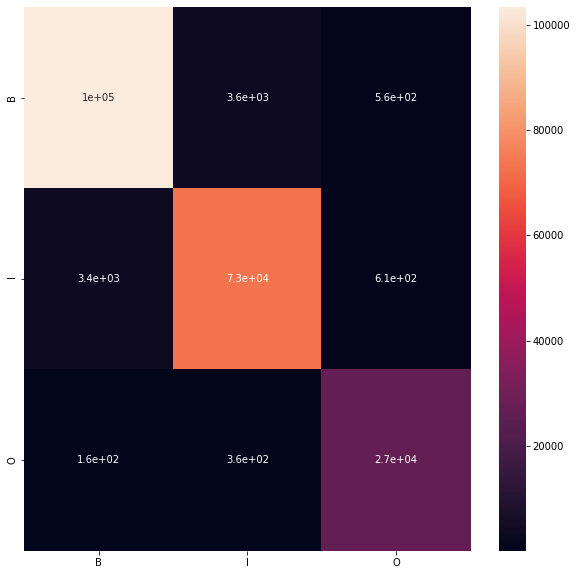

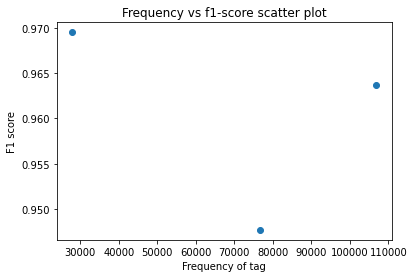

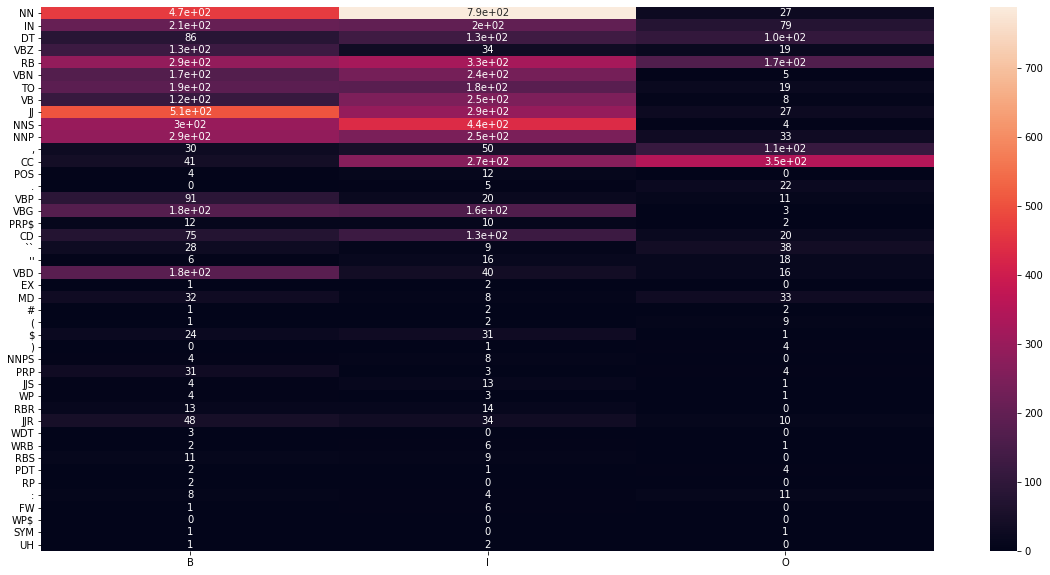

In [ ]:
analyze_evaluation_object(Bi_LSTM_train_results, len(train_sent), mode='train')

The overall accuracy of the Bi-LSTM model is: 94.39386578230287
The sentence accuracy of the Bi-LSTM model is: 37.17693836978131


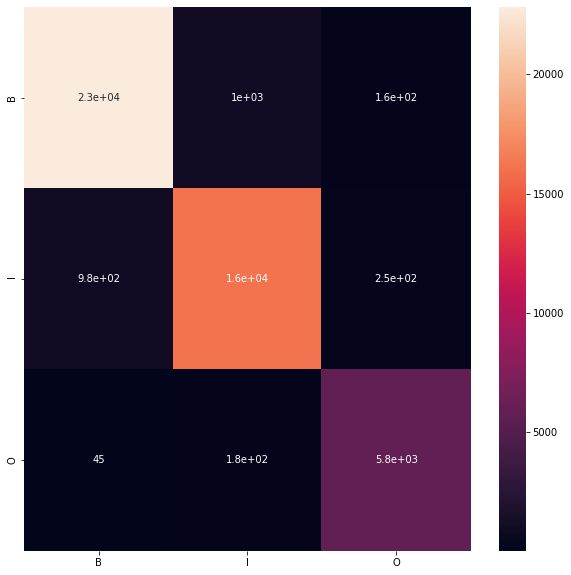

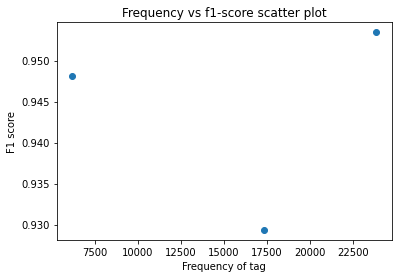

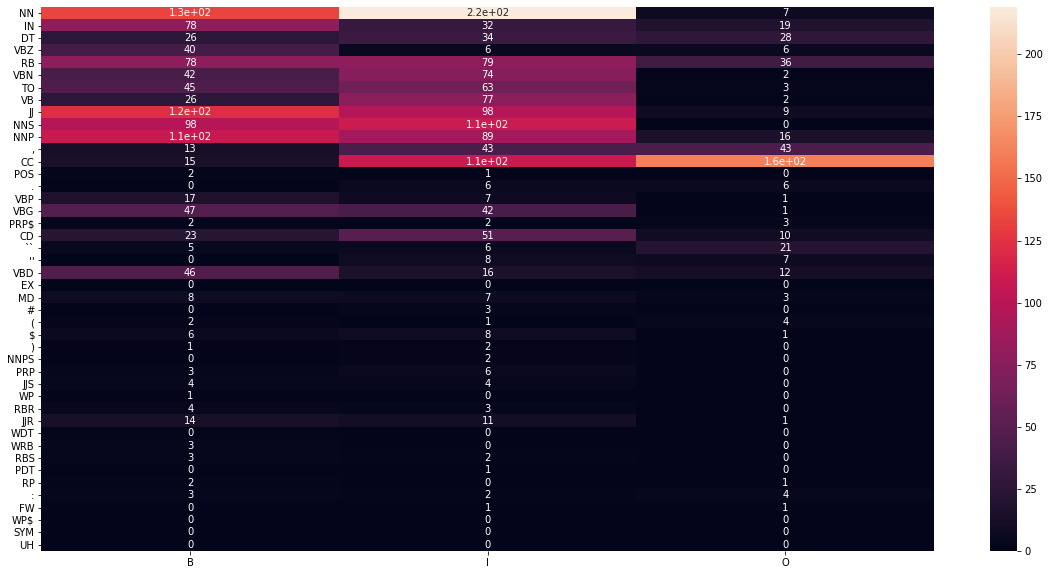

In [ ]:
analyze_evaluation_object(Bi_LSTM_test_results, len(test_sent), mode='test')

In [ ]:
# analysis on mis classified training examples
mis_predicted_sent_id_tags_train = Bi_LSTM_train_results['mis_predicted_sent_id_tags']

# random sampling some of the examples and analyzing the outcome
sampled_args = np.random.choice(len(mis_predicted_sent_id_tags_train), 100, replace=False)

# expected outcome vs actual outcome
with open('Bi_LSTM_mis_classified_sent.txt', 'a') as write_file:
    for index in sampled_args:
        write_file.write('Current sentence: ' + str(mis_predicted_sent_id_tags_train[index][0]) + ' ' + ' '.join(train_sent[mis_predicted_sent_id_tags_train[index][0]]) + '\n')
        write_file.write('----------------------------------------\n')
        write_file.write('Token -x- Predicted Chunk Tag -x- Actual Chunk Tag -x- Actual POS tag\n')
        write_file.write('----------------------------------------\n')

        for token_id in range(len(train_sent[mis_predicted_sent_id_tags_train[index][0]])):
            write_file.write(train_sent[mis_predicted_sent_id_tags_train[index][0]][token_id] + ' ' + chunking_tag_dict.fetch(int(mis_predicted_sent_id_tags_train[index][1][token_id].cpu()),by = 'id') + ' ' + chunking_tag_dict.fetch(int(mis_predicted_sent_id_tags_train[index][2][token_id]), by = 'id') + ' ' + train_pos_tags[mis_predicted_sent_id_tags_train[index][0]][token_id] + '\n')
        write_file.write('----------------------------------------\n')